Examples of interpreting the filters of a CNN that was trained to classify digits from the MNIST dataset.

## Initial setup

In [3]:
import random
import matplotlib.pyplot as plt
import torch
from torch import nn
from scipy.spatial import KDTree
from model_interpretation import mnist_models
import data_util
from model_interpretation import activation_patches

cn = plt.matplotlib.colors.CenteredNorm()

root = 'K:/datasets/classification'
n = 5000
random.seed(42)

ds_train, ds_valid = data_util.get_mnist(root, n)

tensor([10, 11, 17, 22, 38, 52, 59, 61])


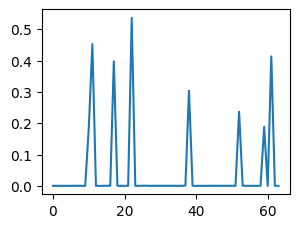

In [4]:
# Load model that was trained on the MNIST dataset. See the "Train sparse models" notebook.
model = mnist_models.CNN()
model.requires_grad_(False)
model.load_state_dict(torch.load('data/weights/cnn_sparse2.pt'))

# Maximum absolute value of each of the 64 filters of the model. We see that only 8 filters are relevant.
max_weights = model.conv.weight.abs().amax(dim=(1,2,3))
print(torch.nonzero(max_weights>0.05).T[0])
plt.plot(max_weights)

## Maximum activation patches

Find the image patches tha maximally activate each filter

Capturing maximum activations...
Batch 9
t1:  0.7944071292877197

Getting patches...
Channel 63 of module conv
t2:  0.1399991512298584


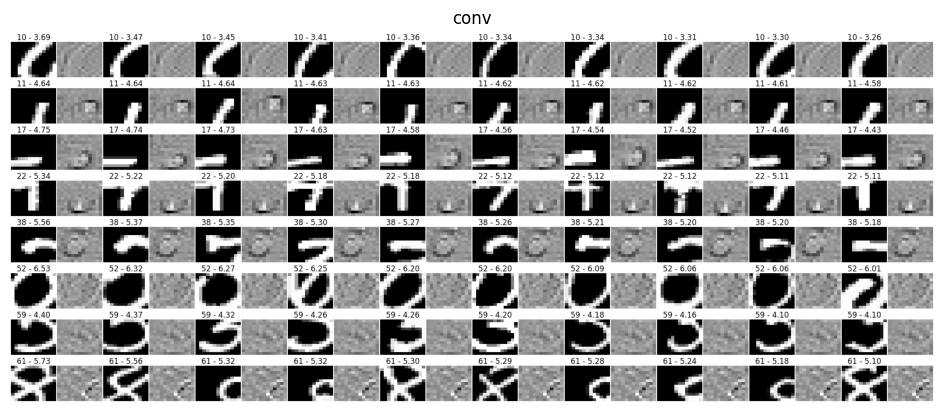

In [5]:
from copy import deepcopy

def transform(img):
    """Normalize image to range [0,255]"""

    img = 255*(img-img.min())/(img.max()-img.min())
    img = img.to(torch.uint8)

    return img

# Hack to make the dataset return image with shape [1,28,28] instead of [28,28]
ds_train_c = deepcopy(ds_train)
ds_train_c.transform = lambda x: data_util.transform(x).reshape(1,28,28)

patches = activation_patches.maximum_activation_patches(model, ['conv'], ds_train_c, n=10, bs=512, threshold=1.)
activation_patches.show_patches(patches, n=10, transform=transform, tile_size=(100,100), width=12);

Each row of the plot corresponds to a filter of the 'conv' layer. The layer has 64 filters but, as mentioned above, only 8 filters are nonzero. Each row shows the 10 patches from the whole dataset that maximally activated that filter. Numbers above each image show the activation value. The "gray" images show the gradients of the activation which respect to the patch. They correspond to relevant regions of the images.

We can see that each filter specialized on a different pattern. 

## Relevance maps

We can identify the filters that were relevant to classify a given image. For the identified filters, we can also get the regions of the image that activated the filters the most.

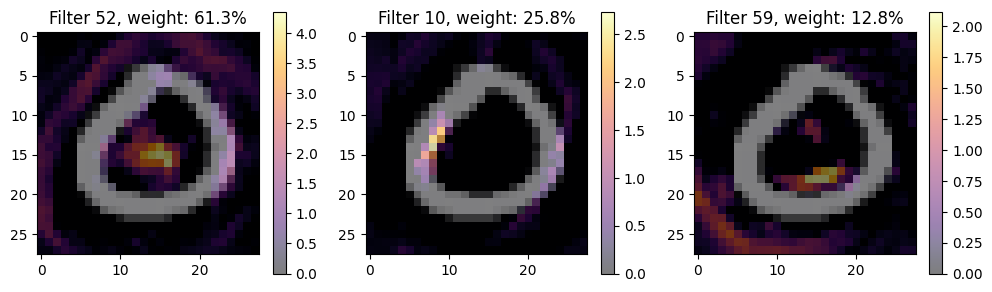

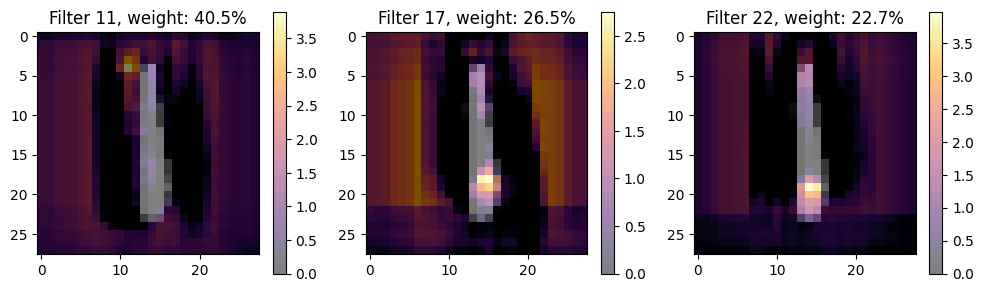

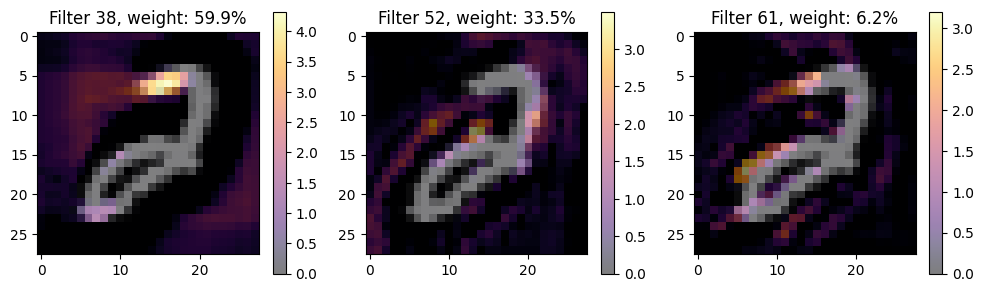

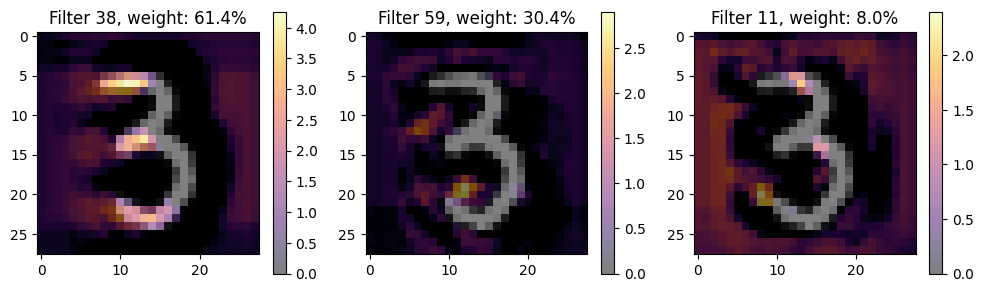

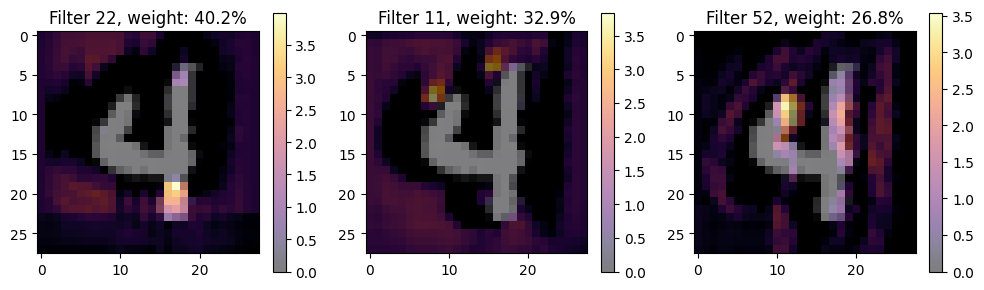

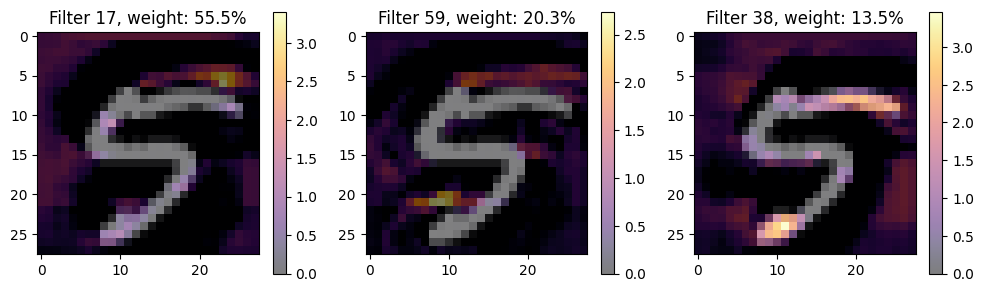

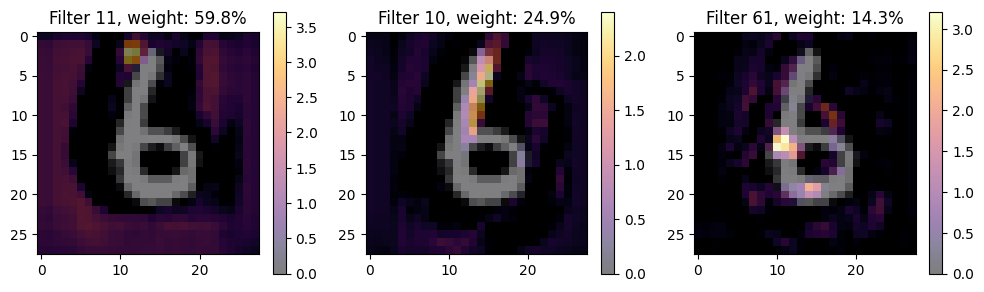

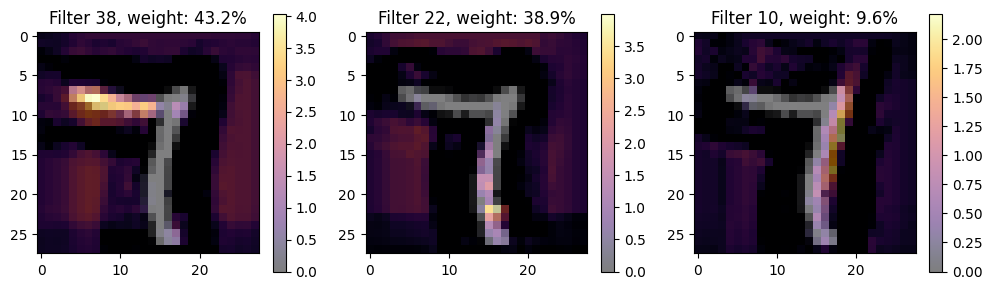

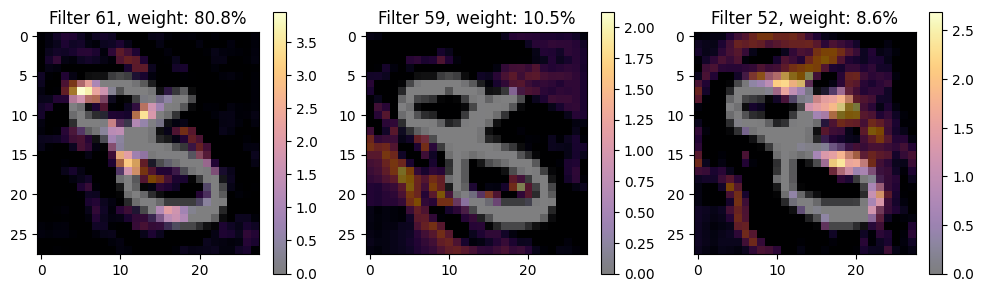

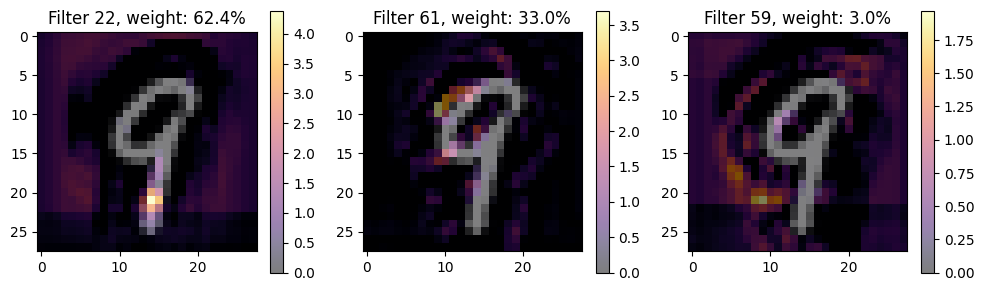

In [10]:
def prototypes(model, ds):
    '''Find samples at the center of each class (warning, average might not be at the peak of the distribution)'''

    data = torch.zeros((len(ds), 64))
    labels = torch.zeros(len(ds), dtype=torch.long)
    for idx, (img, label) in enumerate(ds):
        res = model.pool(model.conv(img[None,None])).squeeze()
        data[idx] = res
        labels[idx] = label
        
    tree = KDTree(data)
    imgs = []
    for idx in range(10):
        mean = data[labels==idx].mean(dim=0)
        d, sample_idx = tree.query(mean)
        imgs.append(ds[sample_idx][0][None])

    return imgs

def interpret(img, model, target, n=5):
    """Find the filters that where the most relevant to classify the image. 
    Also returns the activation maps of the filter for that image."""

    # Classification layer
    w = model.fc.weight
    # Activation maps
    acts = model.conv(img[None])
    # Pooled features
    acts_pool = model.pool(acts).squeeze()
    # The score of each class is given by sum(acts_pool*w[target]). Thus, 
    # cont below will contain the relevance of each feature to the class score.
    cont = acts_pool*w[target]
    # Normalize between [0,1]
    cont = 100*cont/cont[cont>0].sum()
    acts = acts.squeeze()

    cont_inds = torch.argsort(cont, descending=True)
    cont_s = cont[cont_inds]

    maps = []
    for idx in range(n):
        feature_idx = cont_inds[idx]
        att = nn.functional.relu(acts[feature_idx])
        maps.append((att, feature_idx, cont_s[idx]))

    return maps

def plot_maps(img, maps):
    
    n = len(maps)
    plt.figure(figsize=(10, 3))
    for idx, (map, feature_idx, cont) in enumerate(maps):
        plt.subplot(1, n, idx+1)
        plt.imshow(img[0], 'gray')
        plt.imshow(map, 'inferno', alpha=0.5)
        plt.colorbar()
        plt.title(f'Filter {feature_idx}, weight: {cont:.1f}%')
    plt.tight_layout()

model.to('cpu')
samples = prototypes(model, ds_train)
for c in range(10):
    x = samples[c]
    maps = interpret(x, model, c, n=3)
    plot_maps(x, maps)

# The plots below show the most relevant regions of an image for the three filters that activated the most for that image. 
# Each plot shows the result for a different class.

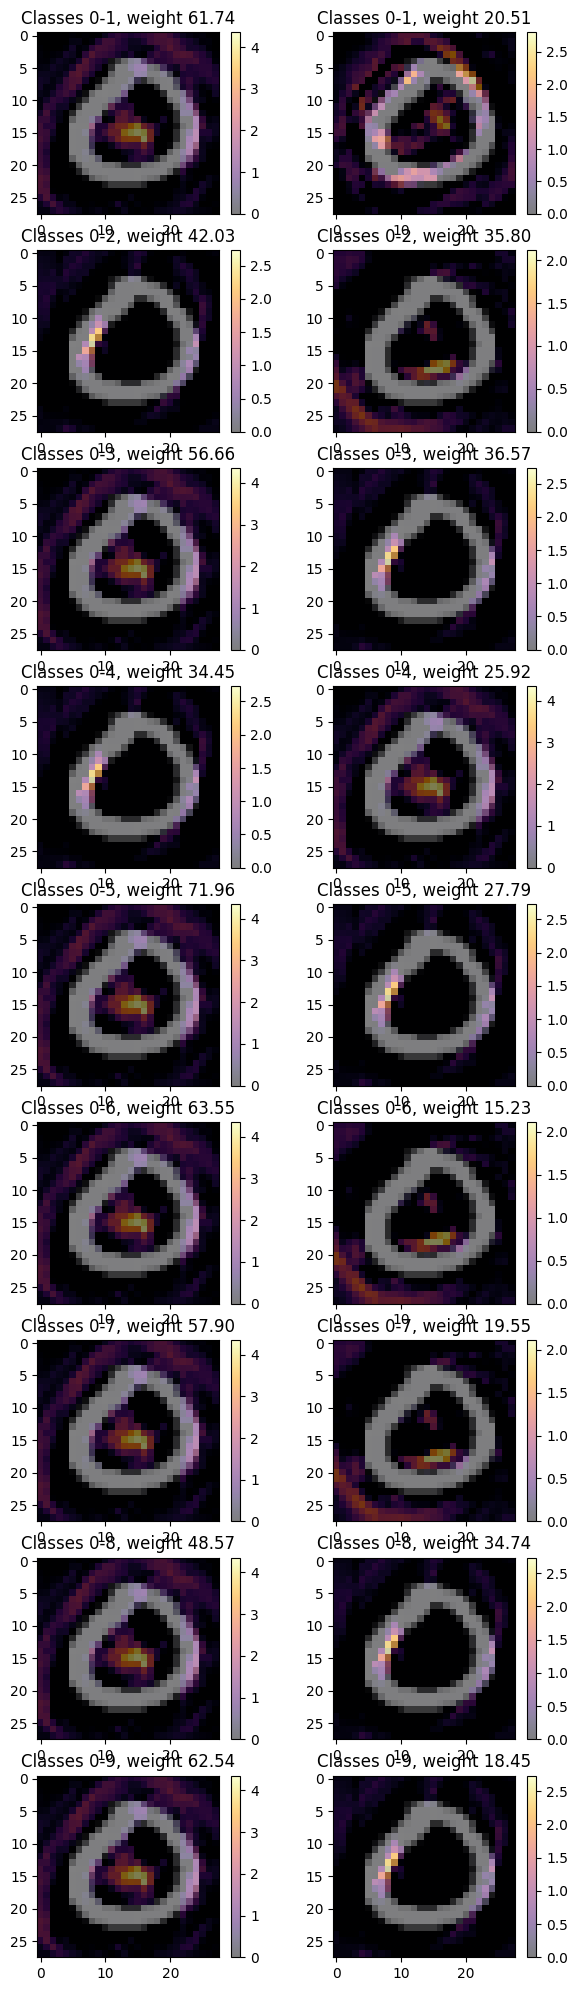

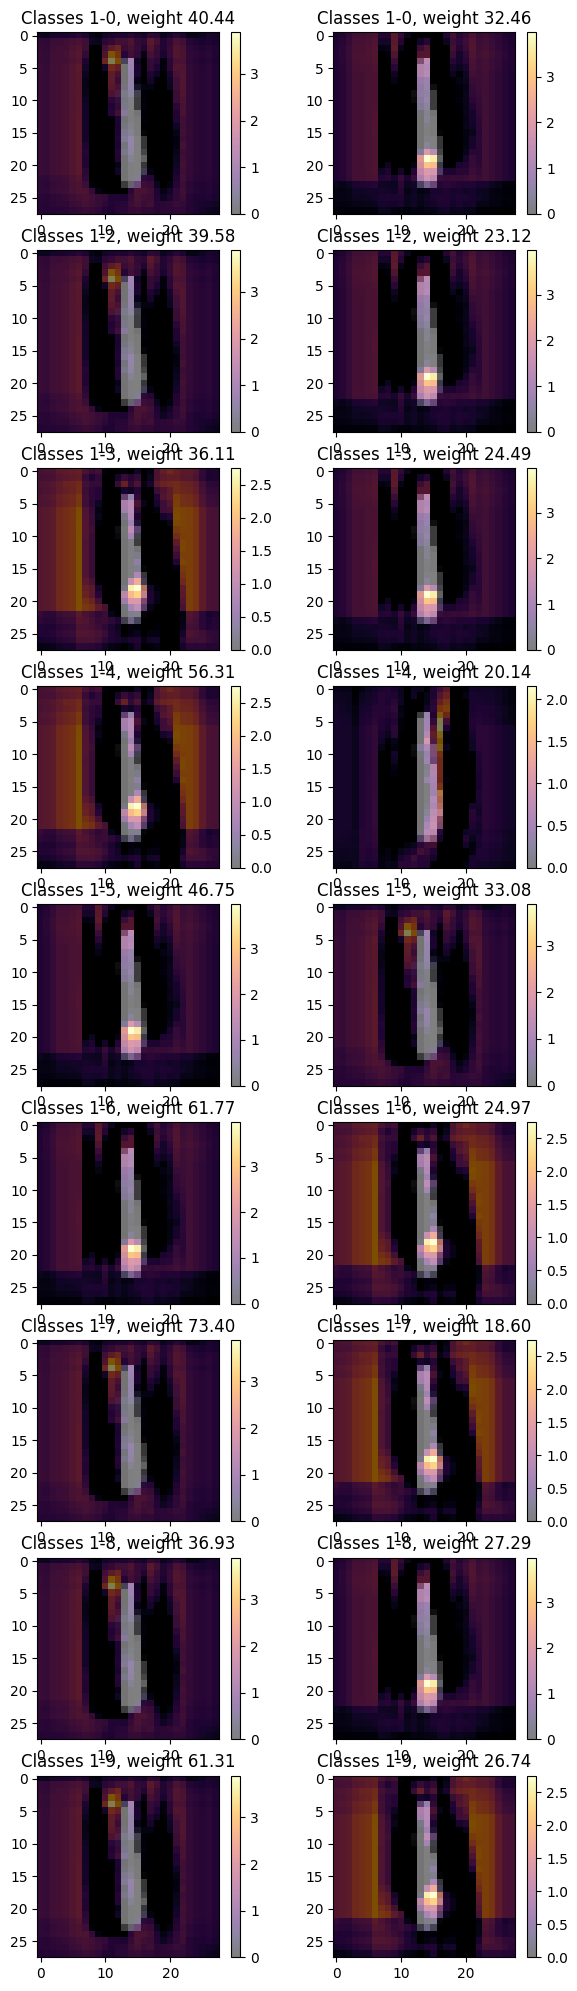

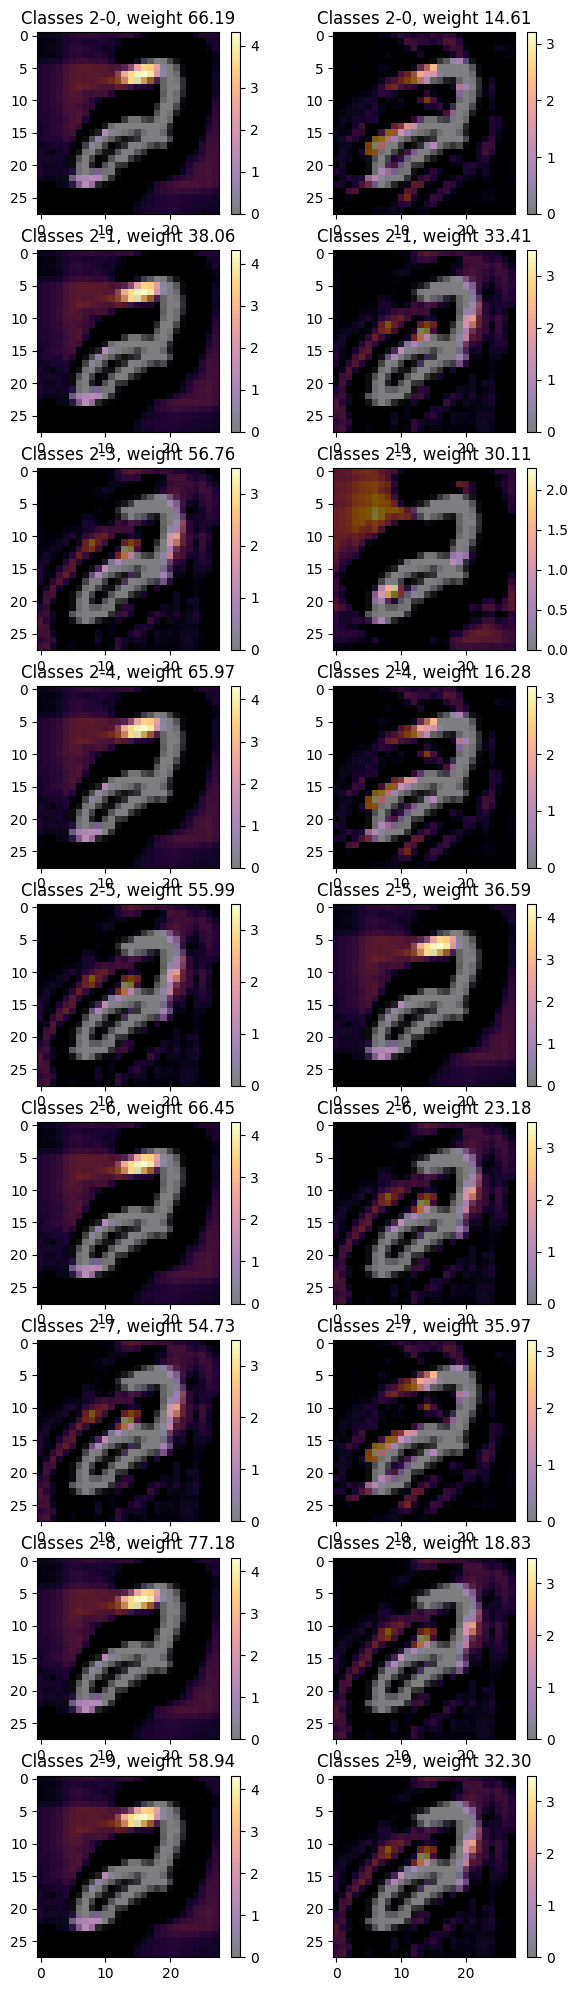

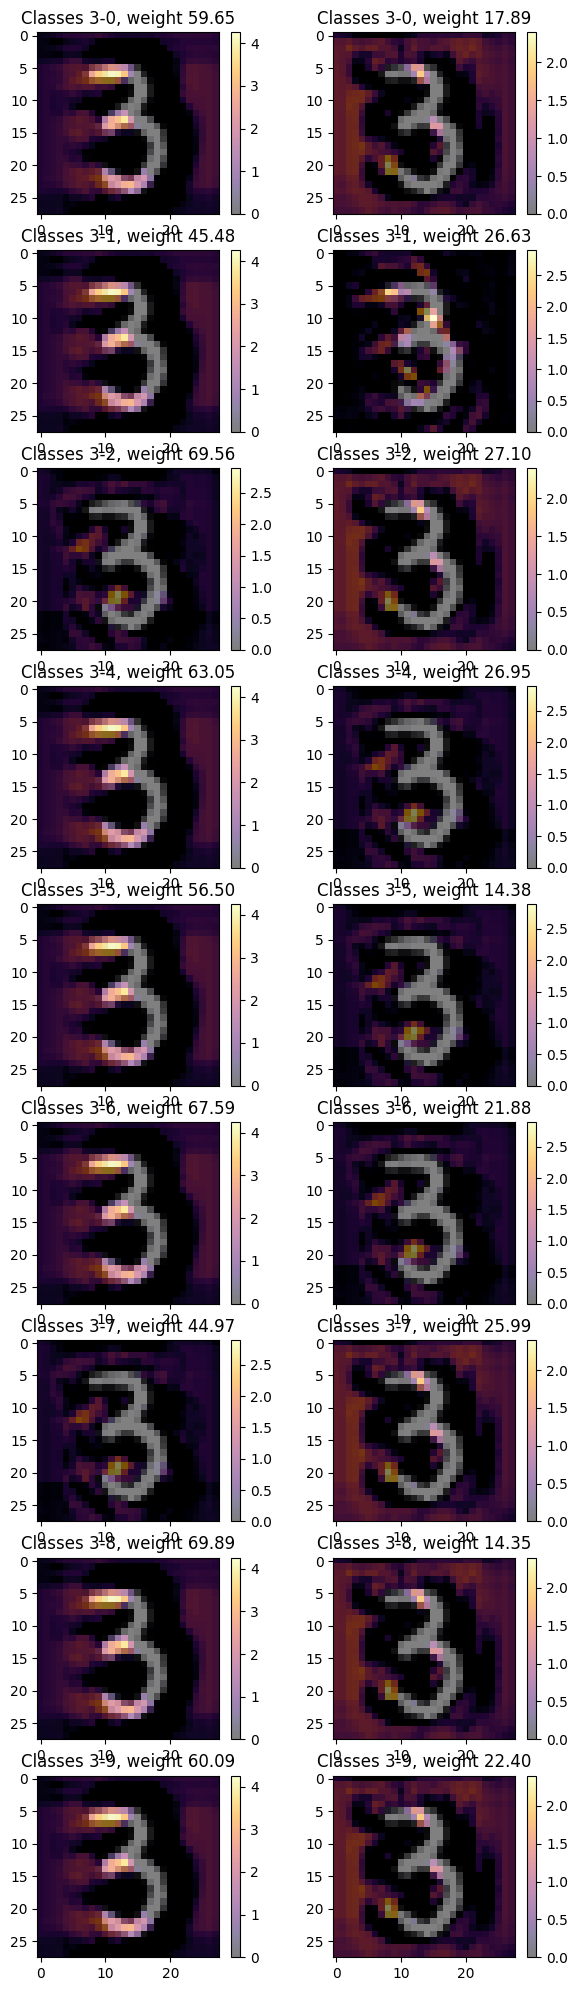

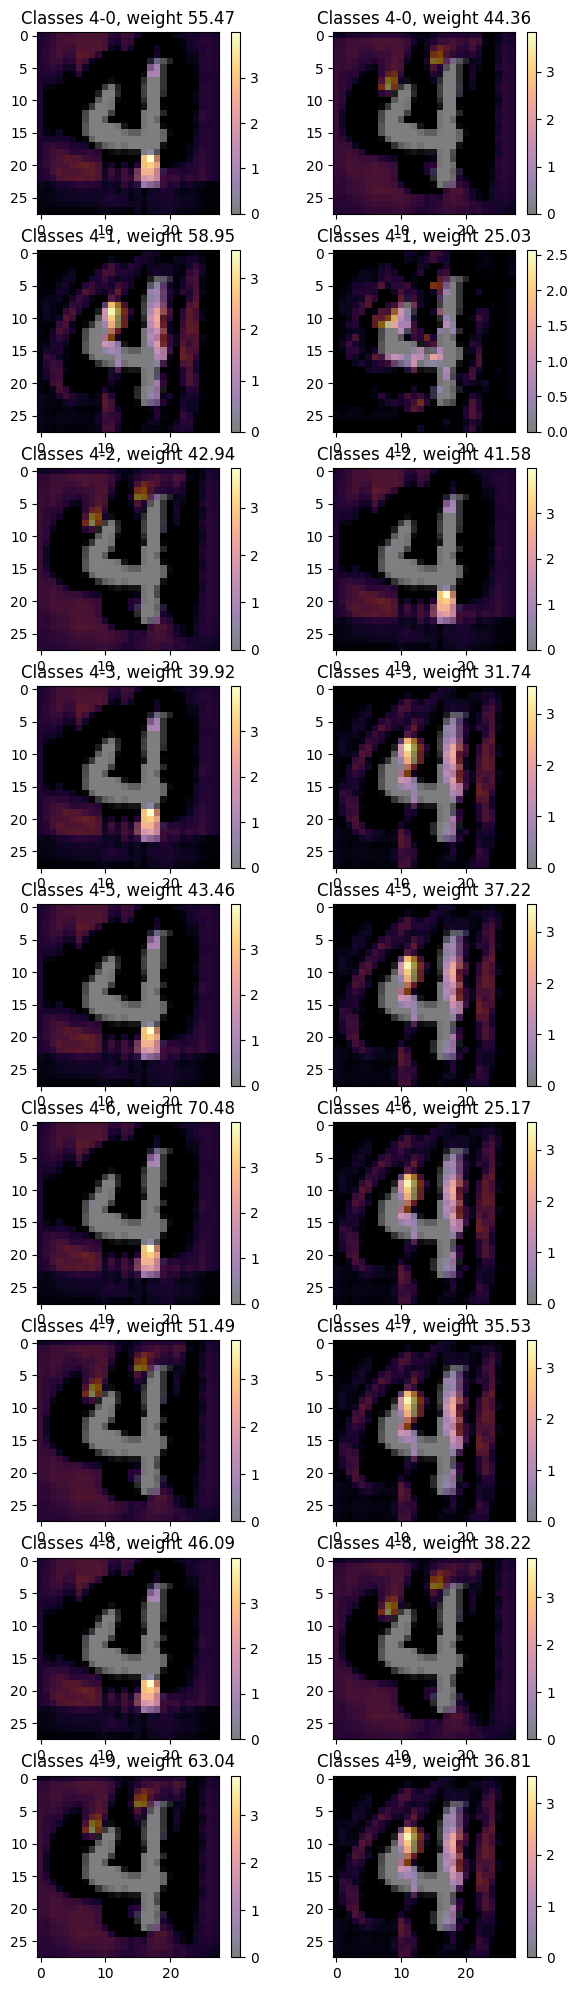

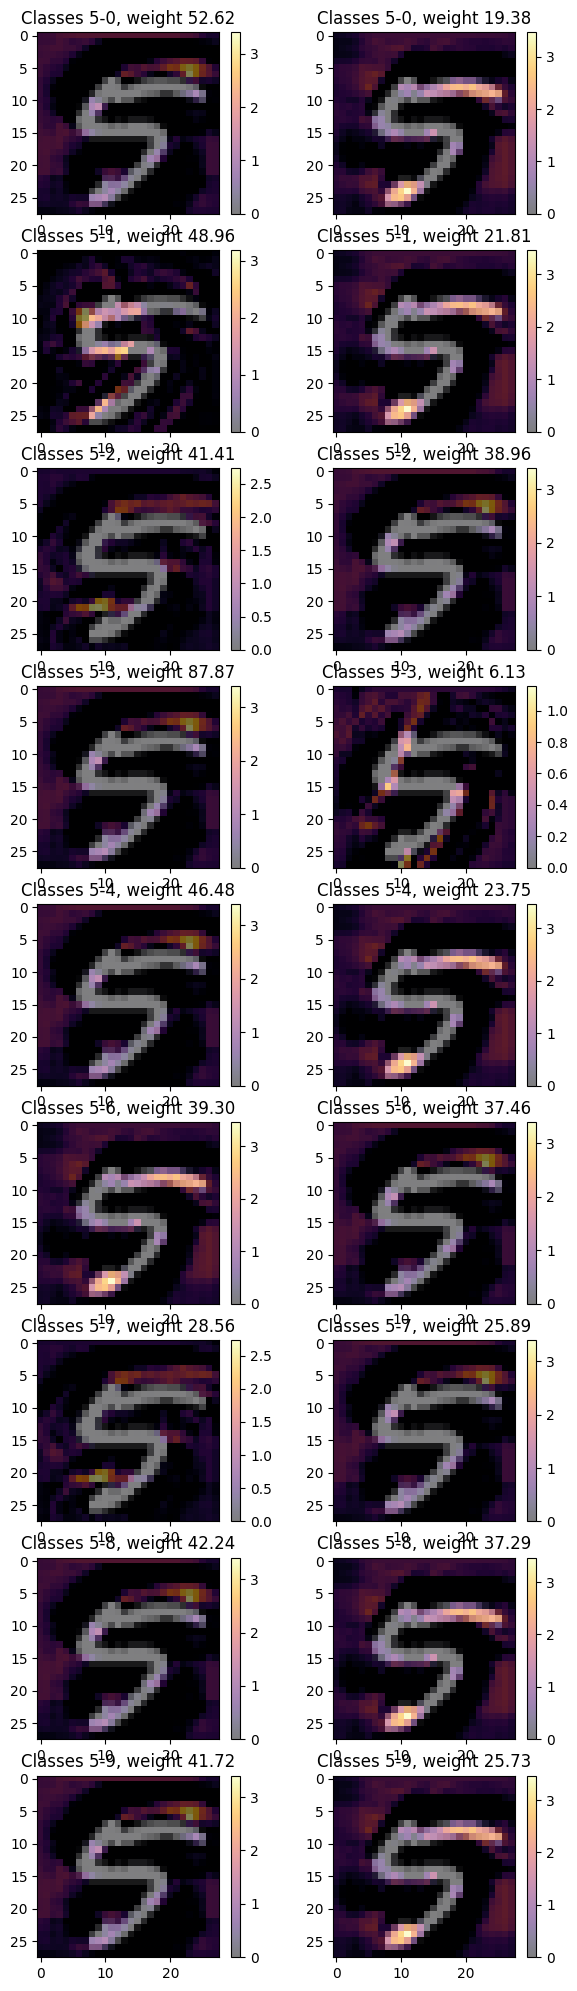

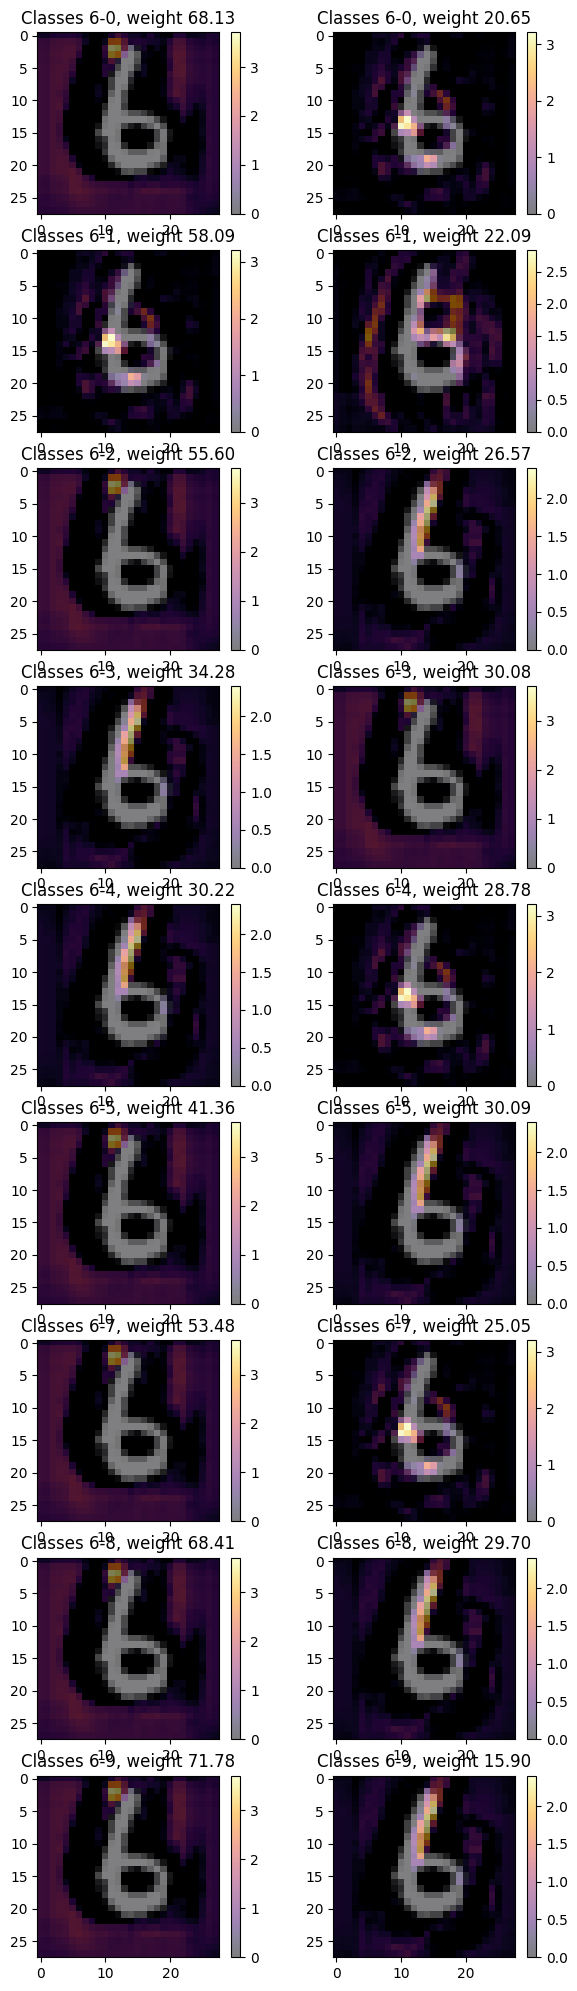

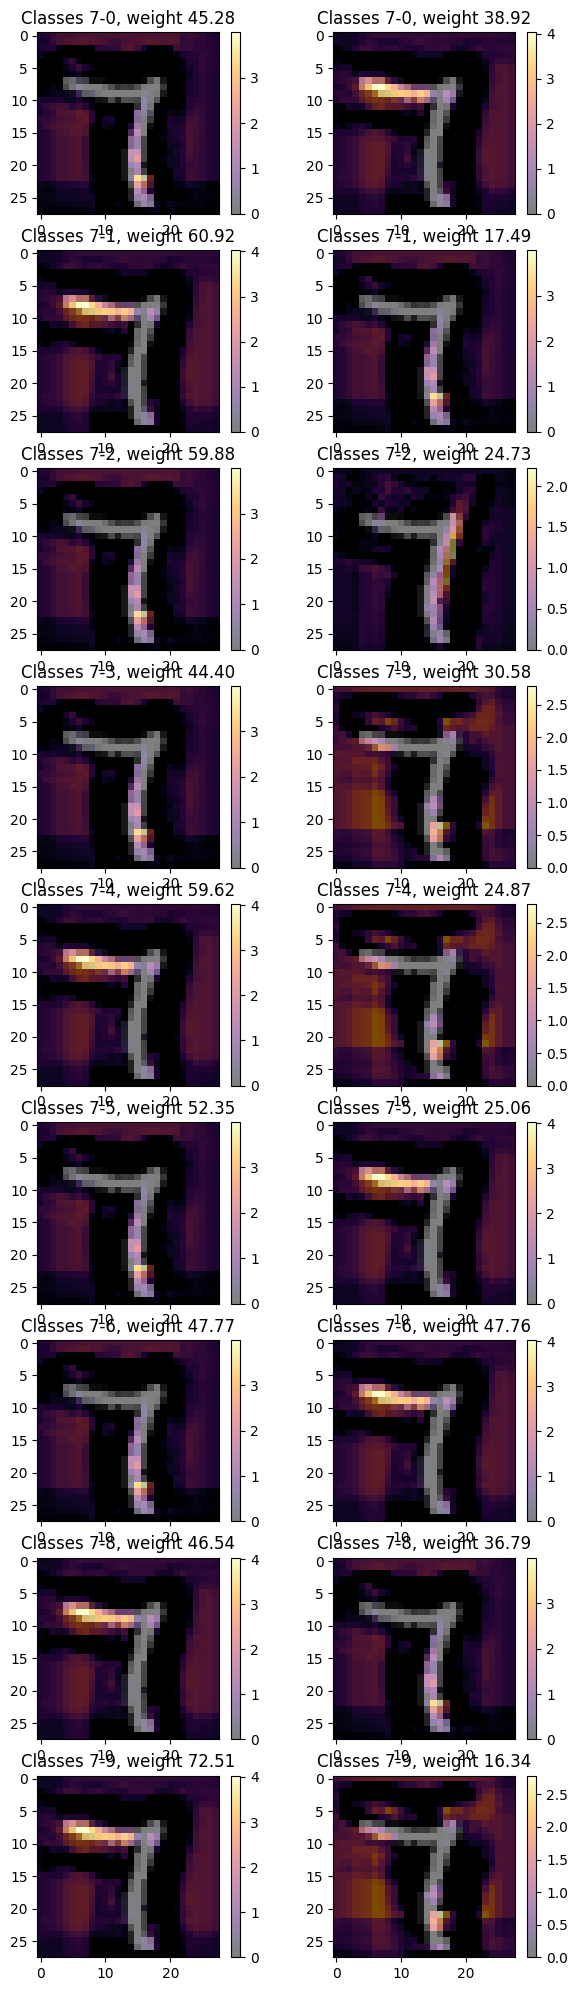

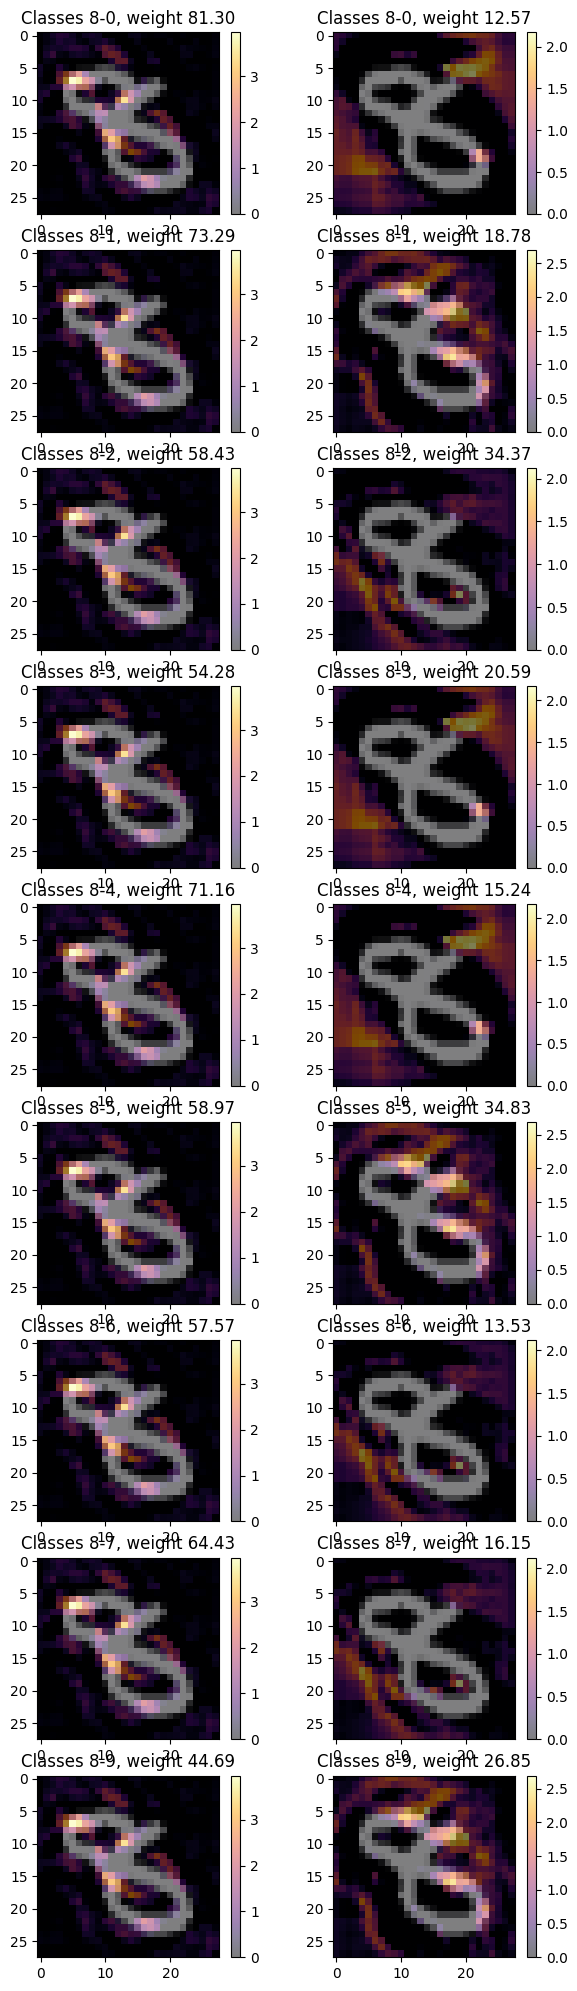

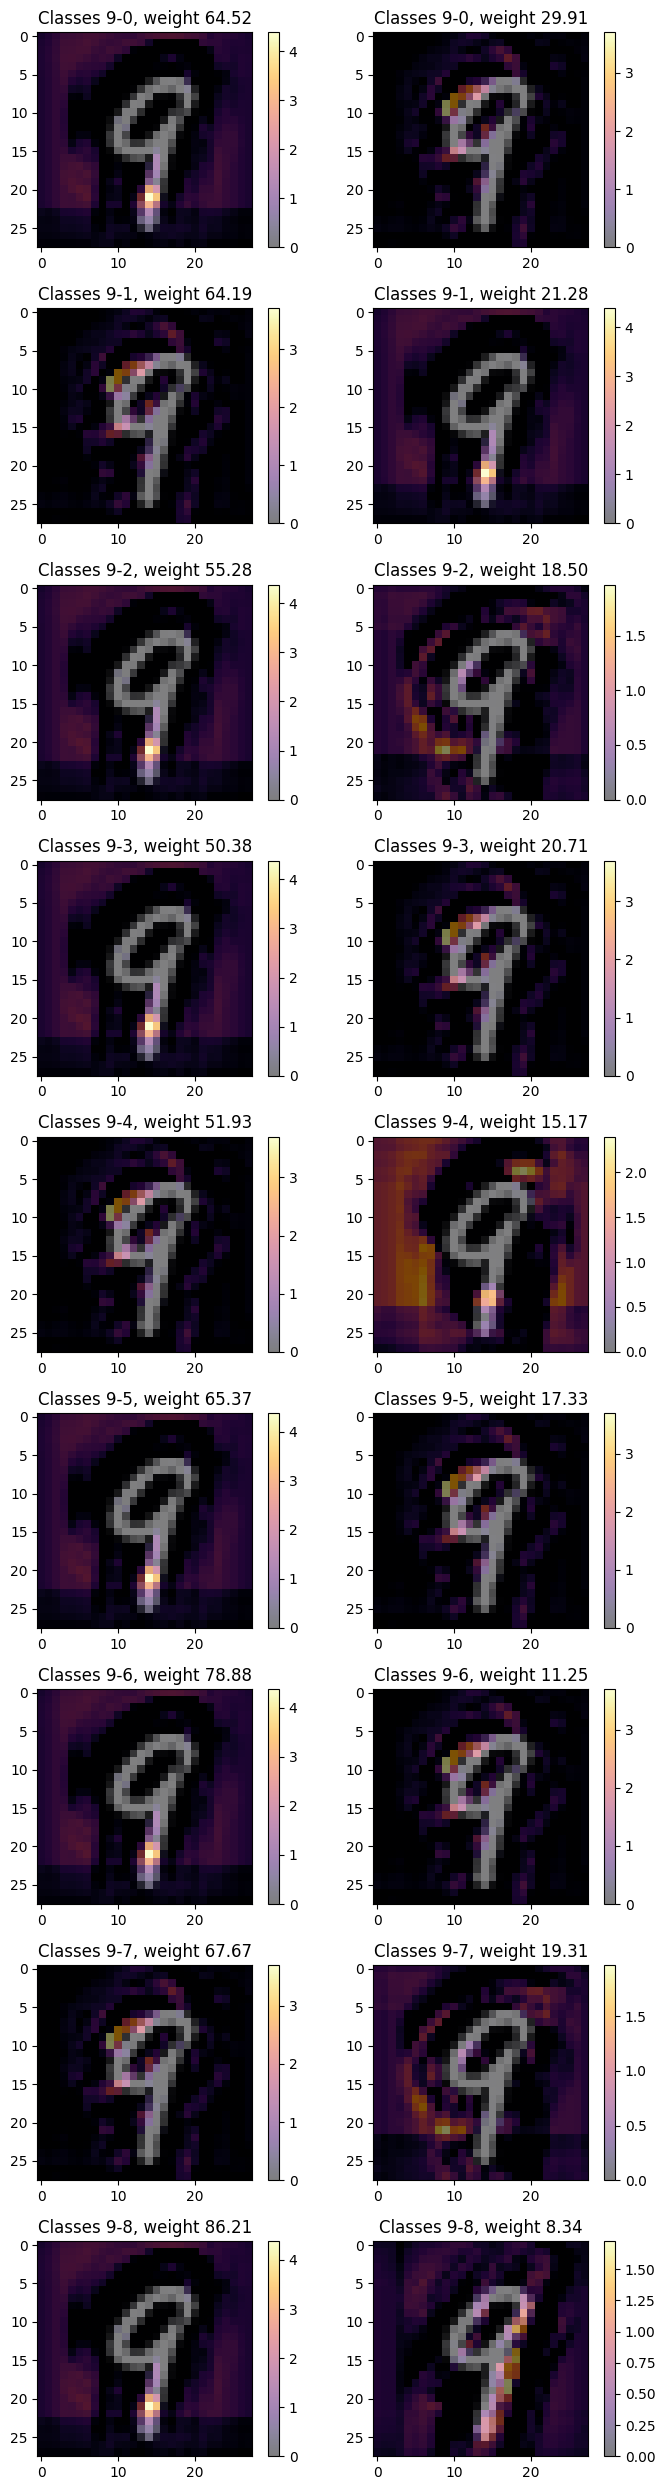

In [11]:
def interpret_pairwise(samples, model, n=2):
    """Identify the filters and image regions that were most important to classify an
    image into class c and not class ci."""

    w = model.fc.weight
    maps = {}
    for i in range(10):
        maps[i] = {}
        for j in range(10):
            if j!=i:
                maps[i][j] = []

    for c_ref in range(10):
        x = samples[c_ref]
        acts = model.conv(x[None])
        acts_pool = model.pool(acts).squeeze()
        acts = acts.squeeze()
        cont_ref = acts_pool*w[c_ref]

        for c_other in range(10):
            if c_other!=c_ref:
                cont_other = acts_pool*w[c_other]
                cont_diff = (cont_ref - cont_other)
                cont_diff = 100*cont_diff/cont_diff[cont_diff>0].sum()
                cont_inds = torch.argsort(cont_diff, descending=True)
                cont_s = cont_diff[cont_inds]

                for idx in range(n):
                    feature_idx = cont_inds[idx]
                    att = nn.functional.relu(acts[feature_idx])
                    maps[c_ref][c_other].append((att, feature_idx, cont_s[idx]))

    return maps

def plot_pairwise_maps(samples, maps):
       
    for c_ref in range(len(samples)):
        x = samples[c_ref]
        maps_c_ref = maps[c_ref]
        plt.figure(figsize=(7, 25))
        k = 0
        for c_other, maps_other in maps_c_ref.items():
            n = len(maps_other)
            for map, feature_idx, cont in maps_other:
                plt.subplot(9, n, k+1)
                plt.imshow(x[0], 'gray')
                plt.imshow(map, 'inferno', alpha=0.5)
                plt.colorbar()
                plt.title(f'Classes {c_ref}-{c_other}, weight {cont:.2f}')
                k += 1
    plt.tight_layout()


maps = interpret_pairwise(samples, model, n=2)
plot_pairwise_maps(samples, maps)

# The first plot below shows the image regions that are relevant to classify the image into class
# 0 instead of class 1, 2, 3, etc. The remaining plots show the same information for the other classes